In [84]:
import  numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import Input
from keras.layers import Dense, Dropout
from keras import Model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

plt.style.use('fivethirtyeight')

## Start

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
df = pd.read_csv("/content/drive/MyDrive/olx_data/otomoto_price_prediction_data.csv")
df.head() 

,make,model,vehicle_year,mileage,engine_capacity,engine_power,gearbox,fuel_type,damaged,is_business,target_price
0,audi,a6,2013,153817.0,1984.0,180.0,automatic,petrol,0,0,69900.0
1,skoda,fabia,2004,115000.0,1390.0,75.0,manual,petrol,0,1,8299.0
2,chevrolet,camaro,2012,299000.0,3600.0,323.0,automatic,petrol,0,1,54500.0
3,bmw,seria-3,2013,155000.0,1995.0,163.0,automatic,diesel,0,0,62000.0
4,renault,talisman,2017,167000.0,1600.0,130.0,automatic,diesel,0,1,52999.0


In [5]:
df.shape

(206207, 11)

## Missing Values

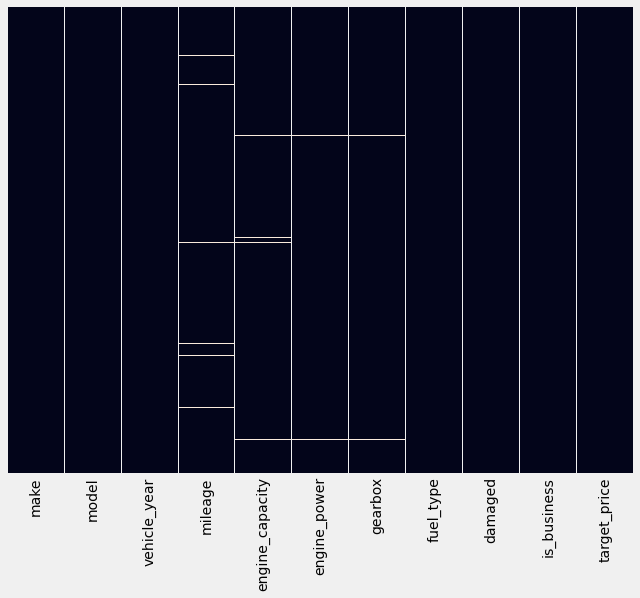

In [87]:
plt.figure(figsize= (10,8))
mask = df.isnull()
sns.heatmap(mask,  yticklabels=False, cbar= False)

Due to excessive data, we can remove all rows containing missing values

In [88]:
df.dropna(axis = 0, inplace= True)

Lets check again to confirm

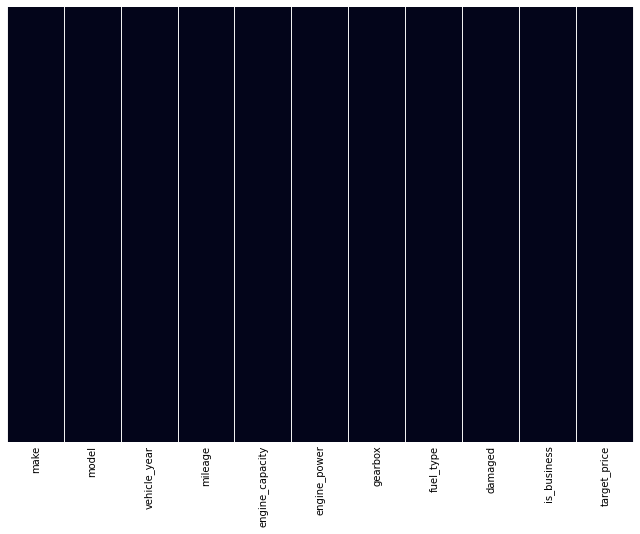

In [8]:
plt.figure(figsize= (10,8))
mask = df.isnull()
sns.heatmap(mask,  yticklabels=False, cbar= False)

## Top 20 occurance of car brands 

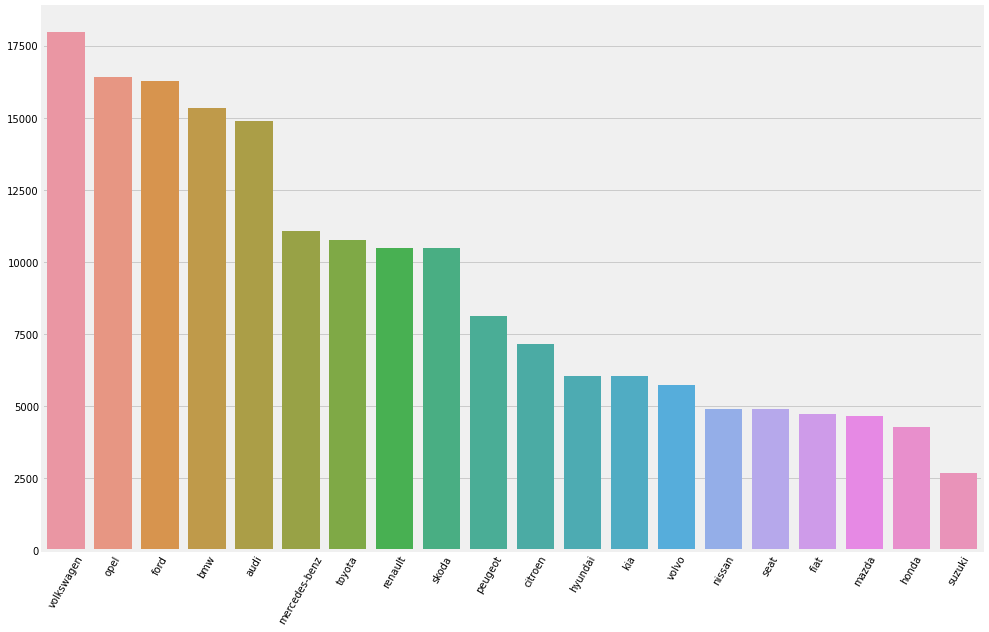

In [9]:
idx = df.make.value_counts().index
count = df.make.value_counts().values
plt.figure(figsize= (15,10))
plt.xticks(rotation = 60)
sns.barplot(x = idx[:20], y = count[:20])

We store the vehicles brand names in a variable "idx" for later analysis

For a given specific car make, the average target_price per year.

In [10]:
def yearly_price(df, make = 'audi'):
  grp = df.groupby(by = ['make', 'vehicle_year'], as_index= False).mean()
  grp = grp[grp['make'] == make]
  plt.figure(figsize= (10,8))
  plt.scatter(x = grp.vehicle_year, y = grp.target_price, label = "Time Analysis of target_price for "+ make)
  plt.legend()
  plt.xlabel("Year")
  plt.ylabel("Average price in a year")
  plt.tight_layout()

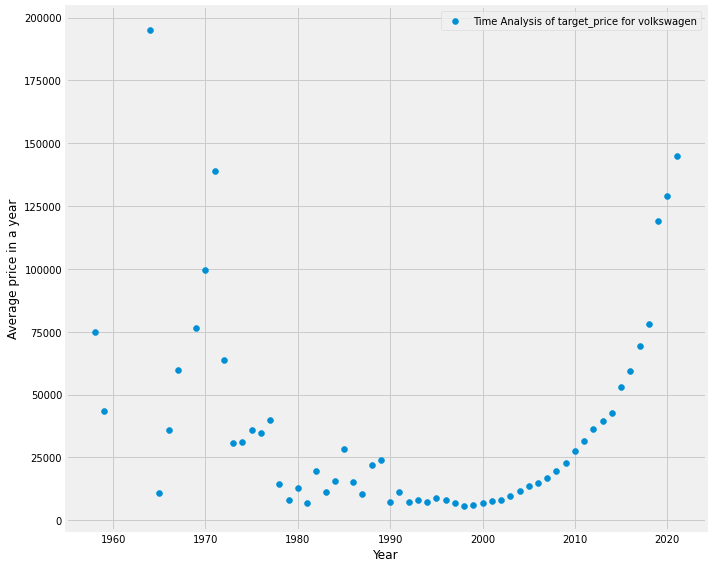

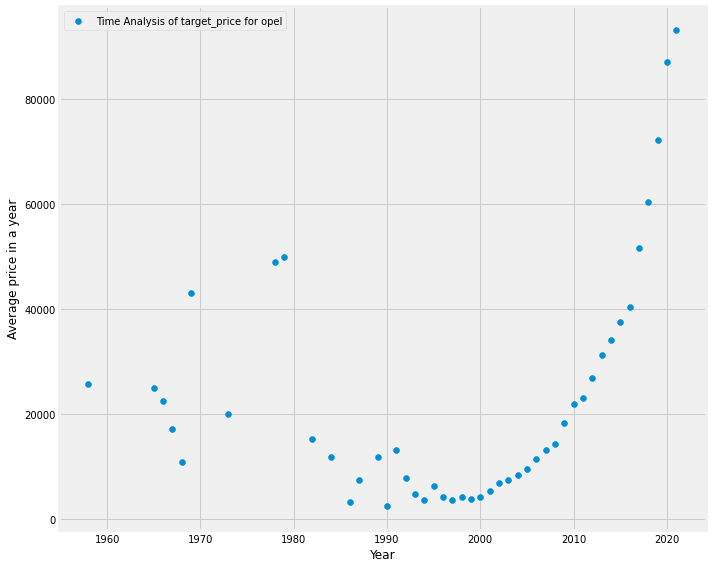

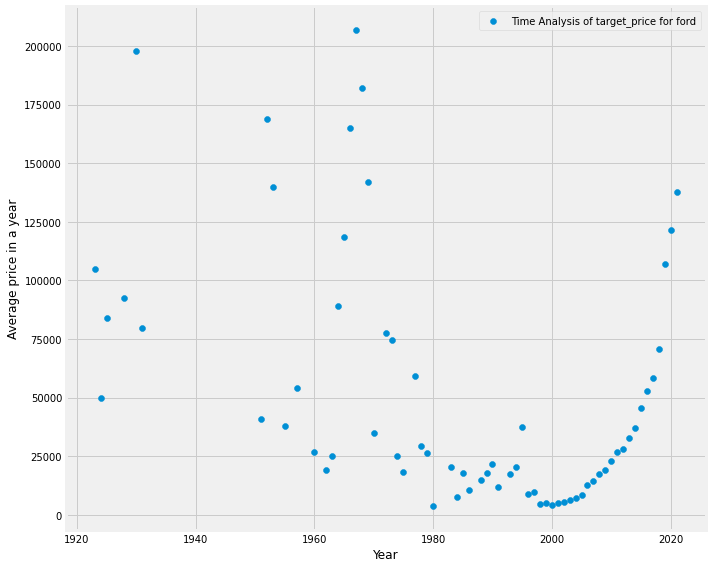

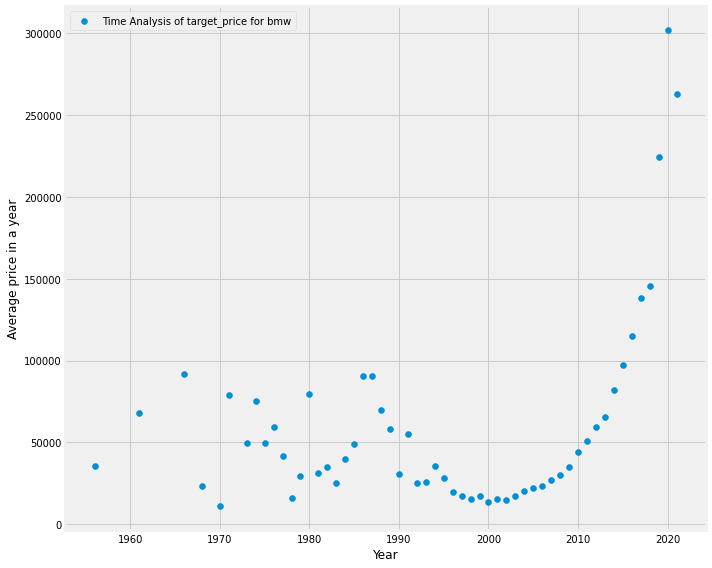

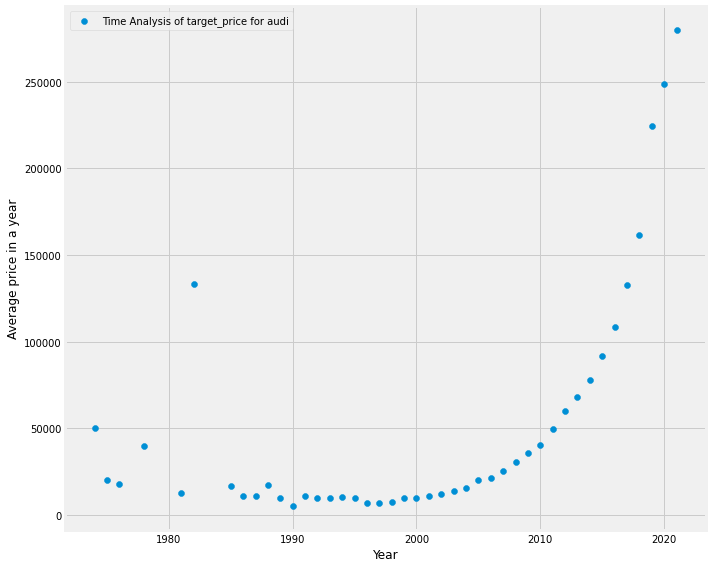

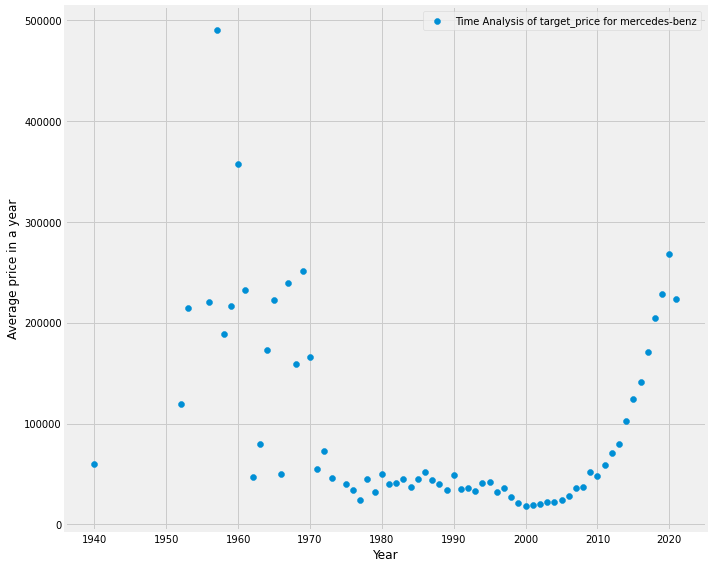

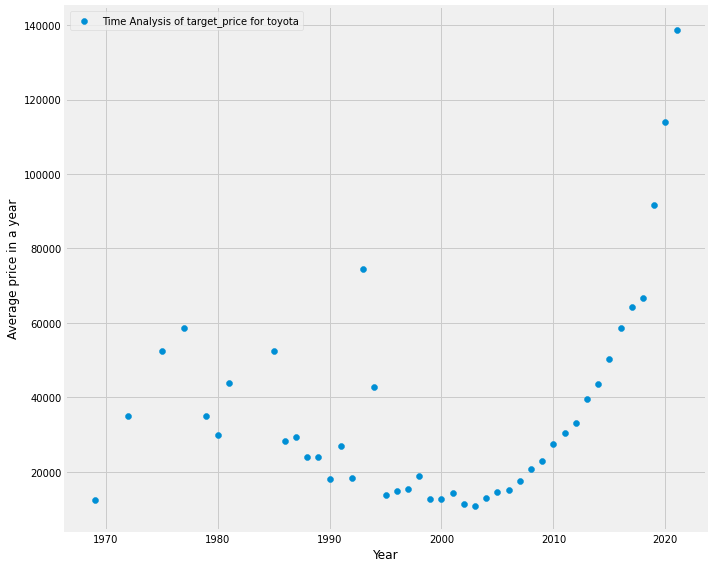

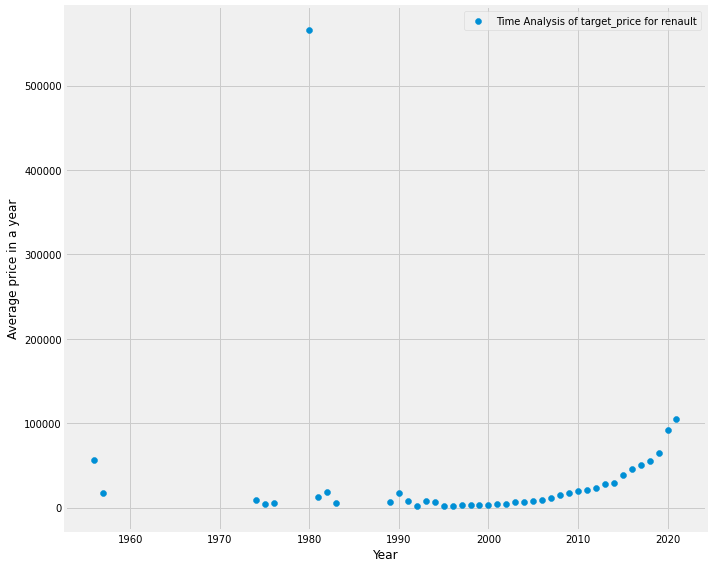

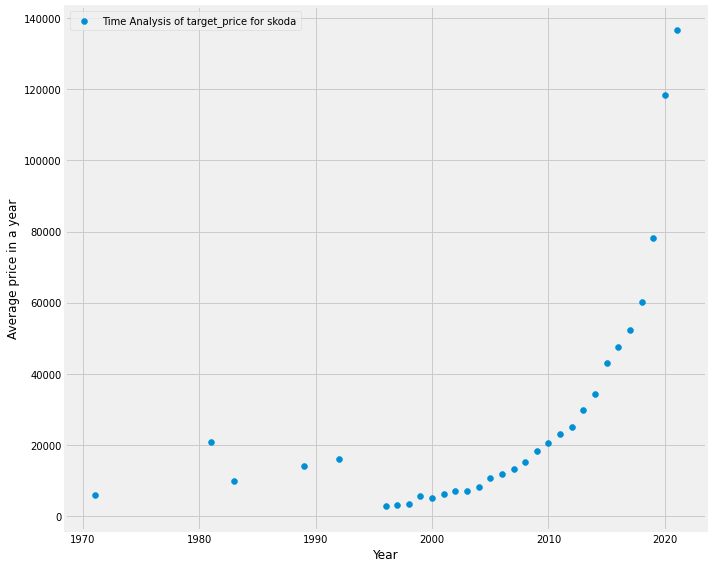

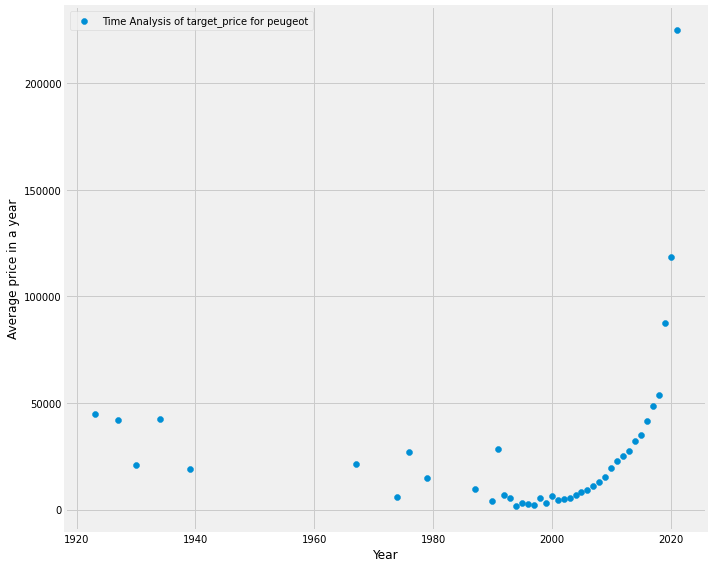

In [11]:
for i in idx[:10]:
  yearly_price(df, i)

It can easily be deduced that in the last decade, the target_price have increased for almost all car makes.

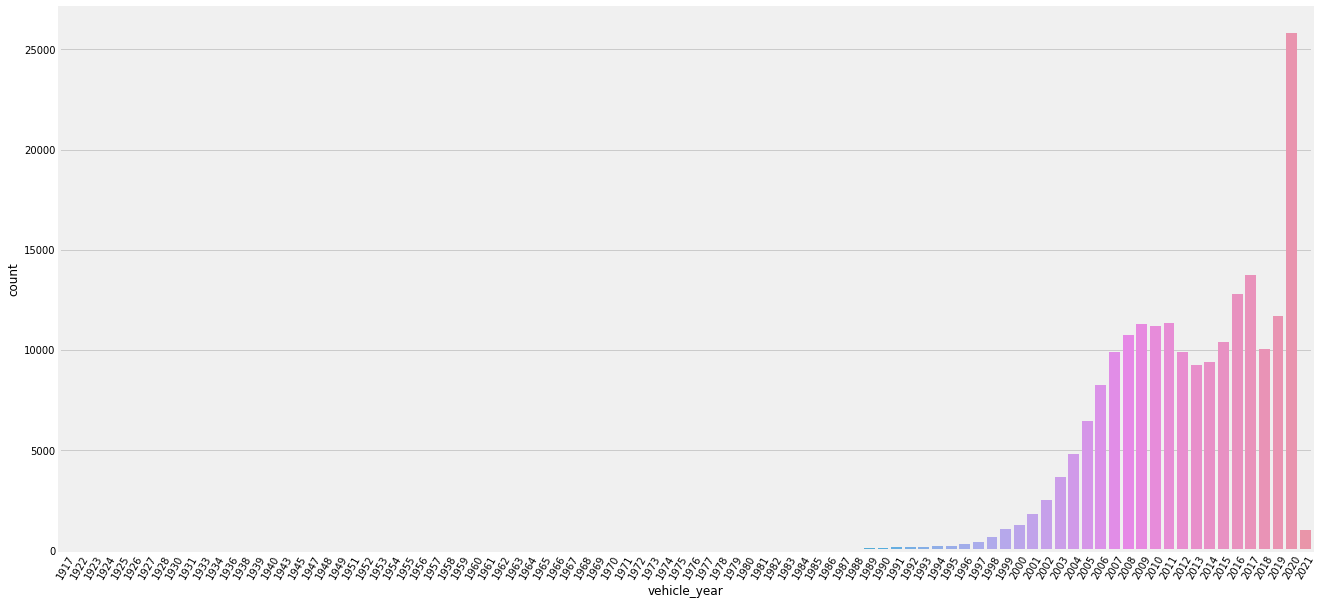

In [12]:
plt.figure(figsize= (20,10))
sns.countplot(x = df.vehicle_year)
_ = plt.xticks(rotation = 60)

The major data comes from year 2000 till 2020.

## Categorical variables analysis

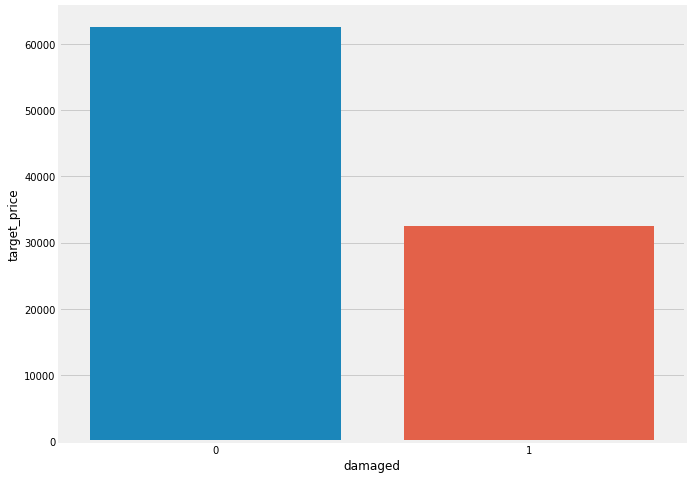

In [13]:
plt.figure(figsize= (10,8))
a = df.groupby(by = 'damaged').mean()
sns.barplot(x = a.index, y = a.target_price)

All the damaged vehicles have approximately half the price as compared to undamaged vehicles.

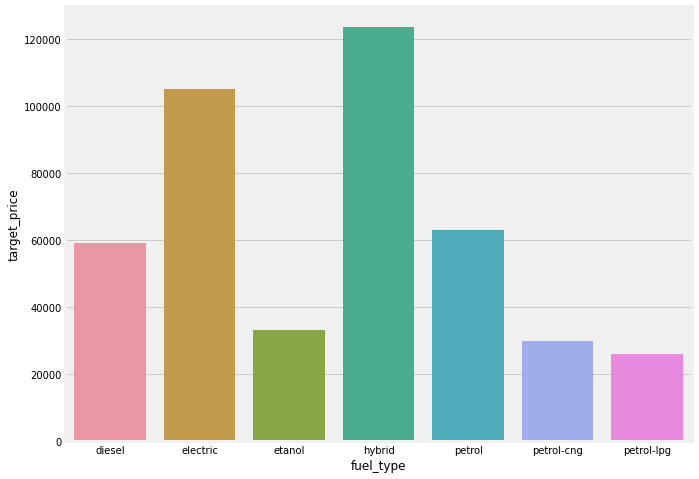

In [14]:
plt.figure(figsize= (10,8))
a = df.groupby(by = 'fuel_type').mean()
sns.barplot(x = a.index, y = a.target_price)

Hybrid and Electric vehicles prove to be more expensive than other fuel types.

In [15]:
def make_fuel(df, idx, fuel_type = 'petrol'):
  a = df.groupby(by = ['make', 'fuel_type'], as_index= False).mean()
  vals = []
  makes = []
  for make in idx:
    b = a[(a.make == make) & (a.fuel_type == fuel_type)]
    if b.shape[0] == 0:
      continue
    vals.append(b.target_price.values.item())
    makes.append(make)
  if not vals:
    print("NO CAR MAKE OPERATE USING THIS FUEL_TYPE")
    return
  plt.figure(figsize= (10,8))
  sns.barplot(x = makes, y = vals)
  plt.title("Average price of car brand for a specific fuel_type")

The analysis describes for a given set of car makers, how there average price changes given a specific fuel_type.

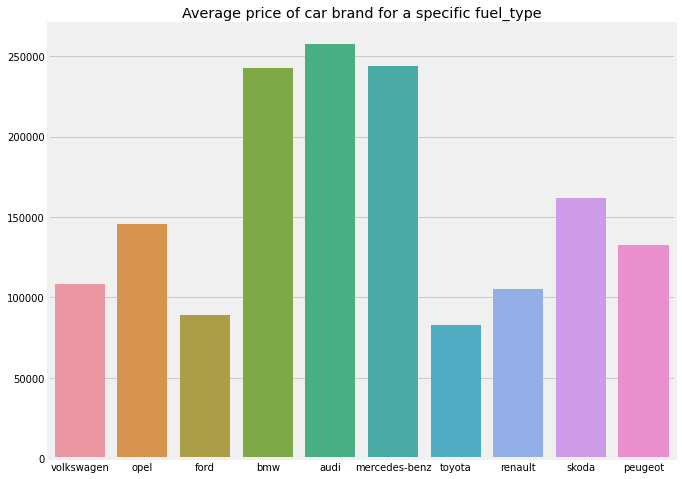

In [16]:
make_fuel(df, idx = idx[:10], fuel_type='hybrid')

bmw, audi and merecedes benz have relatively higher prices for hybrid vehicles

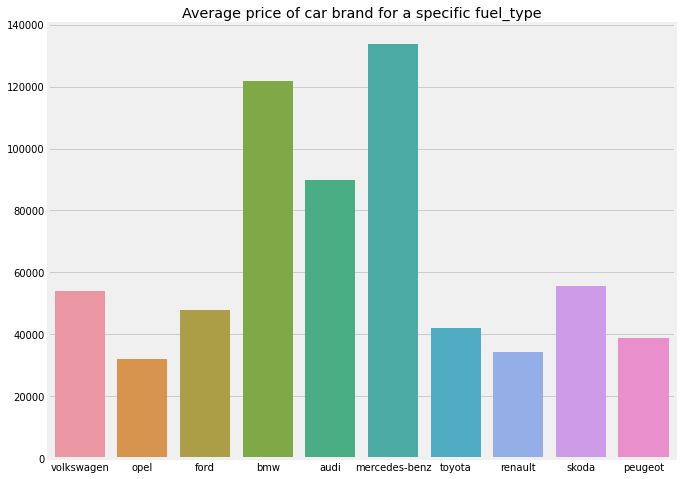

In [17]:
make_fuel(df, idx = idx[:10], fuel_type='petrol')

bmw, audi and merecedes benz also have relatively higher prices for petrol operated vehicles. These brands tend to be more expensive then other car makers.

## Numerical Variables Analysis

#### Engine Capacity

Text(0.5, 1.0, 'Lower quartile, median, upper quartile and outliers of engine_capacity')

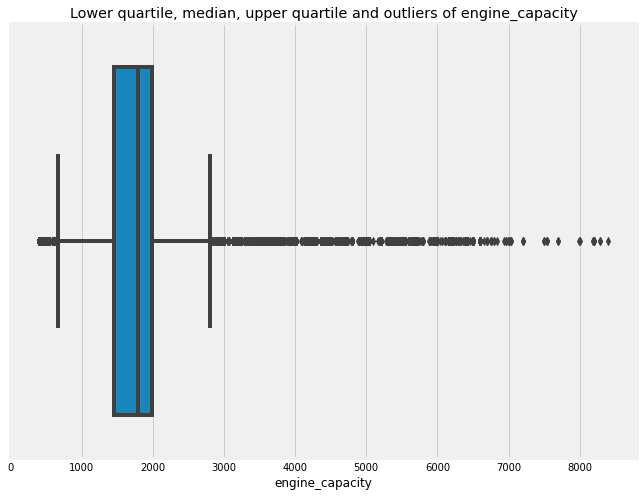

In [18]:
plt.figure(figsize= (10,8))
sns.boxplot(x = df.engine_capacity)
plt.title("Lower quartile, median, upper quartile and outliers of engine_capacity")

#### Outlier Removal

Using the figure above, we can disregard all vehicles having engine_capacity greater than 5000 otherwise it will effect our model.

In [89]:
df = df[df.engine_capacity < 5000]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Histogram for Engine Capacity')

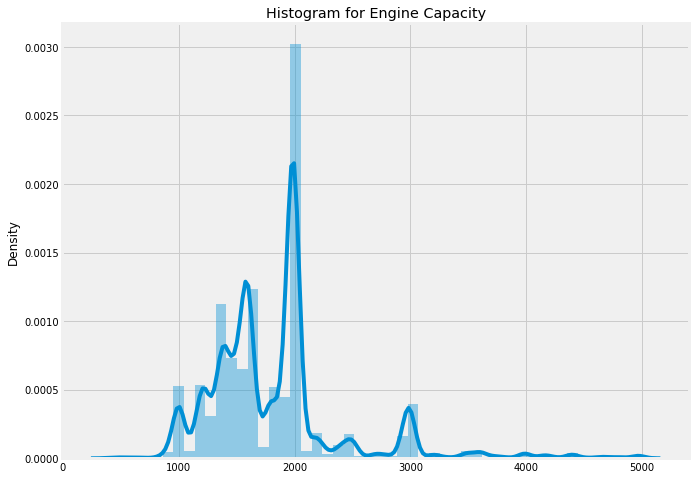

In [20]:
plt.figure(figsize= (10,8))
sns.distplot(x = df.engine_capacity)
plt.title("Histogram for Engine Capacity")

Most values of engine_capacity lie in the range of 1800 to 2200. It approximately forms a bell shape. Mean and Median almost coincide with each other which shows a very less right sided skewed data distribution.

#### Engine_Power

Text(0.5, 1.0, 'Lower quartile, median, upper quartile and outliers of engine_power')

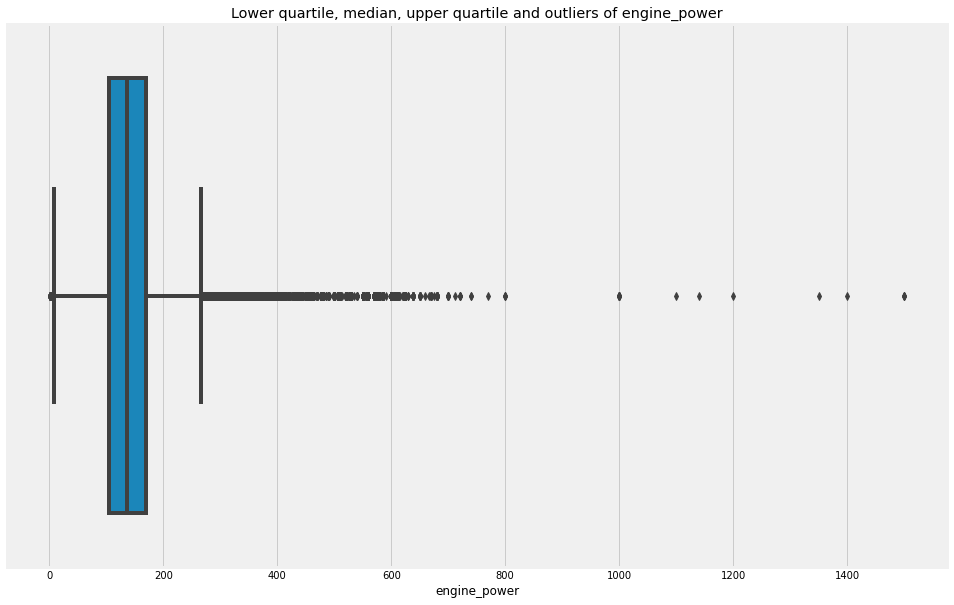

In [21]:
plt.figure(figsize= (15,10))
sns.boxplot(x = df.engine_power)
plt.title("Lower quartile, median, upper quartile and outliers of engine_power")

#### Outlier Removal

Using the figure above, we can disregard all vehicles having engine_power greater than 600 otherwise it will effect our model.

In [90]:
df = df[df.engine_power<600]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Histogram for Engine_power')

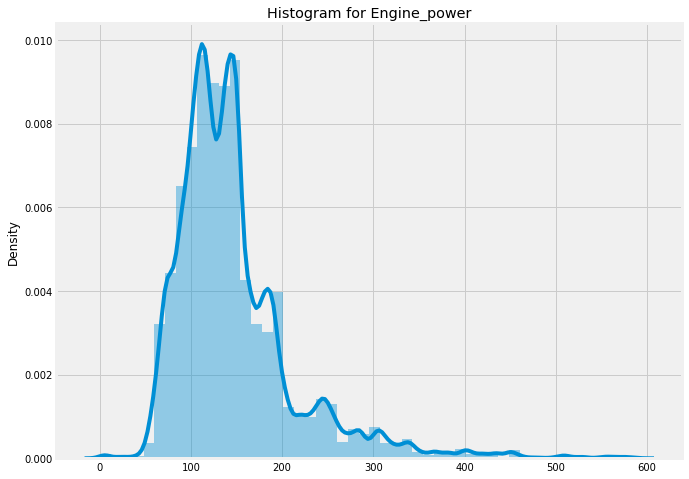

In [23]:
plt.figure(figsize= (10,8))
sns.distplot(x = df.engine_power, kde = True)
plt.title("Histogram for Engine_power")

A very good approximation of bell shape. Most values lie between 150 to 200. Mean and Median almost coincide with each other which shows a very less right sided skewed data distribution.

#### Mileage

Text(0.5, 1.0, 'Lower quartile, median, upper quartile and outliers of mileage')

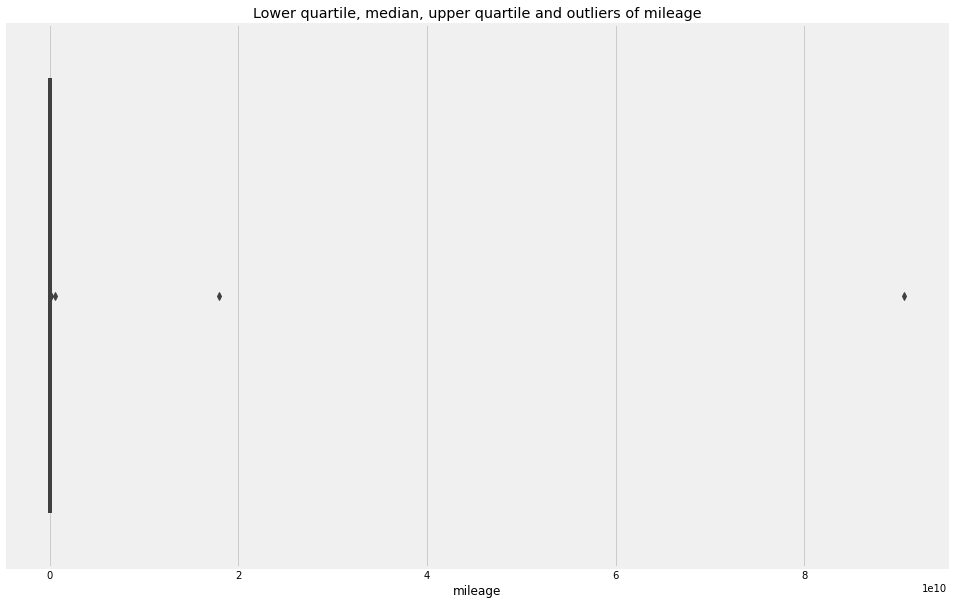

In [24]:
plt.figure(figsize= (15,10))
sns.boxplot(x = df.mileage)
plt.title("Lower quartile, median, upper quartile and outliers of mileage")

The figure clearly depicts presence of outliers hence lets look at some statistical measures.

In [25]:
np.mean(df.mileage)

679736.5682529195

In [26]:
np.min(df.mileage)

1.0

In [27]:
np.max(df.mileage)

90606125000.0

In [28]:
np.median(df.mileage)

139000.0

In [29]:
np.quantile(df.mileage, 0.75)

199000.0

The median and the upper quartile values are far smaller than mean which depicts that the mean value has been effected by outliers.

In [91]:
df[df.mileage>450000].shape

(389, 11)

#### Outliers Removal

We consider to take all values of mileage less than 450000 which would only remove 389 examples from the data which is bearable.

In [92]:
df = df[df.mileage < 450000]

Text(0.5, 1.0, 'Lower quartile, median, upper quartile and outliers of mileage')

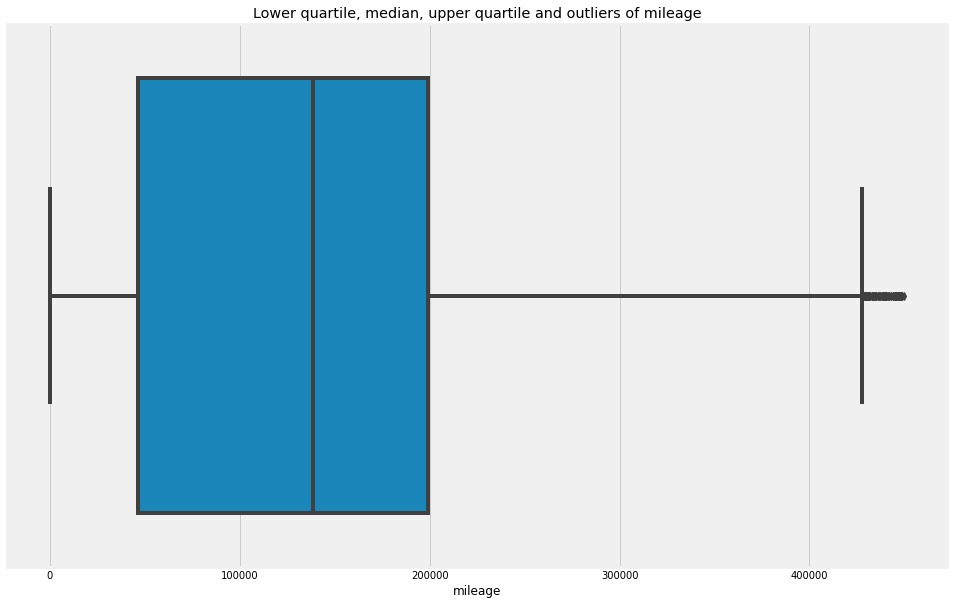

In [32]:
plt.figure(figsize= (15,10))
sns.boxplot(x = df.mileage)
plt.title("Lower quartile, median, upper quartile and outliers of mileage")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Histogram for Mileage')

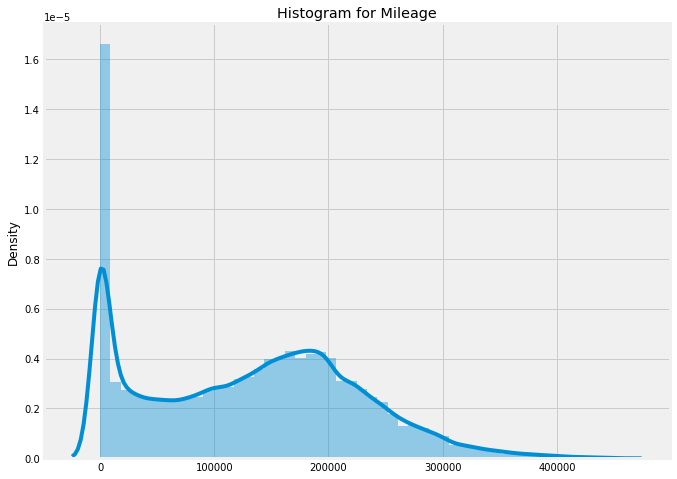

In [33]:
plt.figure(figsize= (10,8))
sns.distplot(x = df.mileage, kde = True)
plt.title("Histogram for Mileage")

Most vehicles seem to have mileage under 100000.

#### Vehicle Year

Text(0.5, 1.0, 'Lower quartile, median, upper quartile and outliers of vehicle_year')

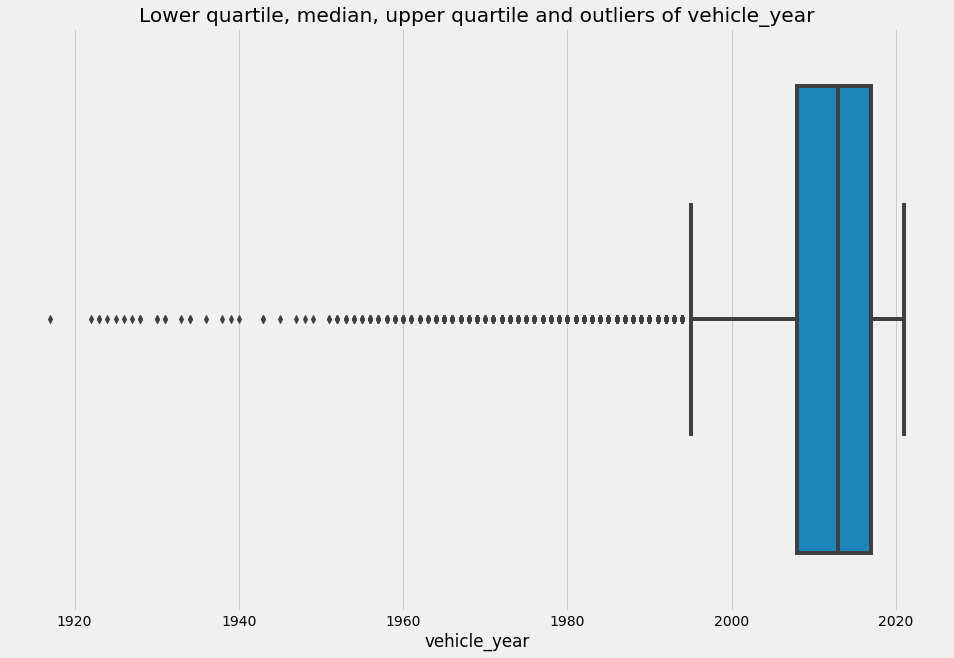

In [93]:
plt.figure(figsize= (15,10))
sns.boxplot(x = df.vehicle_year)
plt.title("Lower quartile, median, upper quartile and outliers of vehicle_year")

In [35]:
df[df.vehicle_year<1990].shape

(931, 11)

#### Outlier Removal

Using the figure above, we consider only the year after 1990. This filter only removes 931 examples.

In [94]:
df = df[df.vehicle_year > 1990]

Text(0.5, 1.0, 'Lower quartile, median, upper quartile and outliers of vehicle_year')

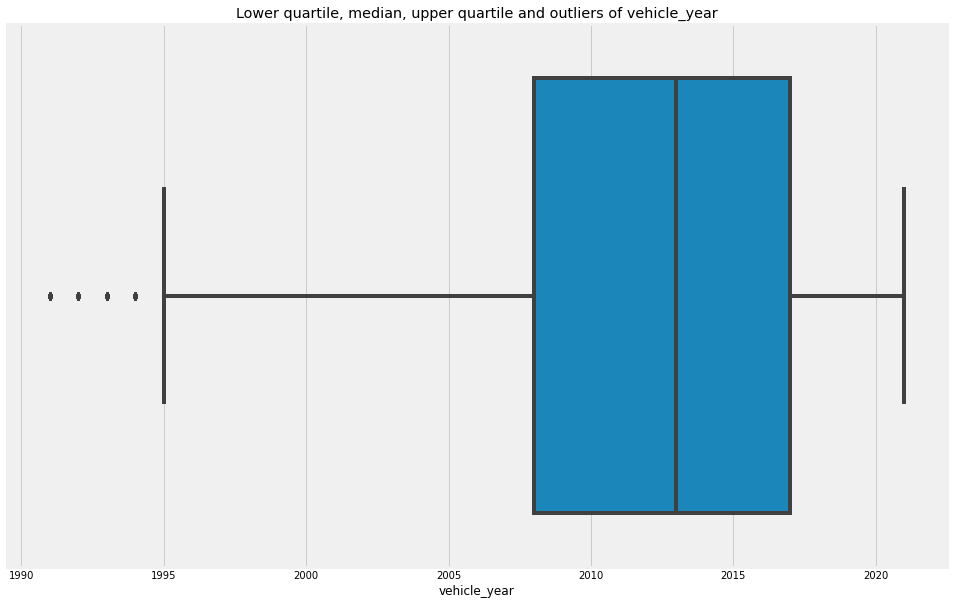

In [37]:
plt.figure(figsize= (15,10))
sns.boxplot(x = df.vehicle_year)
plt.title("Lower quartile, median, upper quartile and outliers of vehicle_year")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Histogram for Vehicle Year')

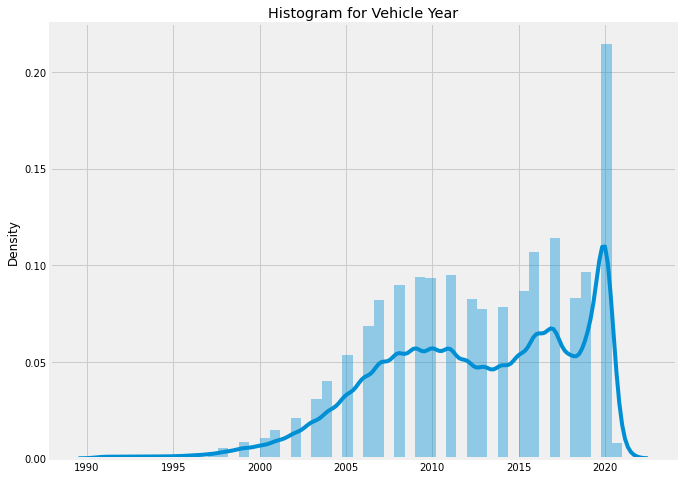

In [38]:
plt.figure(figsize= (10,8))
sns.distplot(x = df.vehicle_year, kde = True)
plt.title("Histogram for Vehicle Year")

Most examples belong to last decade.

## One hot encoded

In order to use categorical variables in model, we need to convert them into one-hot encoded vectors so that all information remain preserved. We have 4 categorical features.

In [95]:
one_hot = pd.get_dummies(df[['make', 'model', 'gearbox', 'fuel_type']])

In [96]:
df = pd.concat([df, one_hot], axis = 1)

In [97]:
df.drop(['make', 'model', 'gearbox', 'fuel_type'], axis = 1, inplace= True)

In [98]:
df.head()

,vehicle_year,mileage,engine_capacity,engine_power,damaged,is_business,target_price,make_abarth,make_acura,make_aixam,make_alfa-romeo,make_alpine,make_aston-martin,make_audi,make_bac,make_bentley,make_bmw,make_brilliance,make_buick,make_cadillac,make_casalini,make_chatenet,make_chevrolet,make_chrysler,make_citroen,make_cupra,make_dacia,make_daewoo,make_daihatsu,make_dfsk,make_dodge,make_ds-automobiles,make_ferrari,make_fiat,make_ford,make_gmc,make_grecav,make_honda,make_hummer,make_hyundai,...,model_xjs,model_xk,model_xk8,model_xl7,model_xlv,model_xm,model_xsara,model_xsara-picasso,model_xt5,model_xv,model_yaris,model_yaris-verso,model_yeti,model_ypsilon,model_yrv,model_z3,model_z4,model_z4-m,model_zafira,model_zdx,model_zoe,model_zr,model_zs,model_zx,gearbox_automated-manual,gearbox_automatic,gearbox_automatic-sequential,gearbox_automatic-stepless,gearbox_automatic-stepless-sequential,gearbox_cvt,gearbox_dual-clutch,gearbox_manual,gearbox_manual-sequential,gearbox_semi-automatic,fuel_type_diesel,fuel_type_electric,fuel_type_hybrid,fuel_type_petrol,fuel_type_petrol-cng,fuel_type_petrol-lpg
0,2013,153817.0,1984.0,180.0,0,0,69900.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2004,115000.0,1390.0,75.0,0,1,8299.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,2012,299000.0,3600.0,323.0,0,1,54500.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,2013,155000.0,1995.0,163.0,0,0,62000.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,2017,167000.0,1600.0,130.0,0,1,52999.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In the numerical features, vehicle_year column exist in thousand figure, mileage exist in lac figure, engine_power in hundred's figure and engine_capacity again happen to be in range of thousands. 

This would surely effect our model as it would give more weight to mileage due to its higher values. The solution is scaling down the values.

For scaling, we are using Standard Scaler which convert values into z-scores and since variables are approximately bell-shaped, it would be a good option. 

For the vehicle_year, we can do scale down using min-max-scaler which would lead to giving higher values to the latest models. For now, I am using the common standard scaler

In [99]:
scaler = StandardScaler()

In [100]:
df.mileage = scaler.fit_transform(df.mileage.values.reshape(-1,1))
df.vehicle_year = scaler.fit_transform(df.vehicle_year.values.reshape(-1,1))
df.engine_capacity = scaler.fit_transform(df.engine_capacity.values.reshape(-1,1))
df.engine_power = scaler.fit_transform(df.engine_power.values.reshape(-1,1))

Now let's prepare our X and Y values for modelling.

In [101]:
y_ii = df.columns == 'target_price'
x_ii = df.columns != 'target_price'
X = df.iloc[:, x_ii].values
y = df.iloc[:, y_ii].values

Train_Test_Split:

20% of examples are kept for testing phase. Out of the rest 80%, again 33.3% values are kept for validation set which will be used for hyperparameter tuning.


In [102]:
xtr, xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)
xtr, xval, ytr, yval = train_test_split(xtr, ytr, test_size=0.33, random_state=42)

In [103]:
print("Number of Train Examples are ", xtr.shape[0])
print("Number of Validation Examples are ", xval.shape[0])
print("Number of Test Examples are ", xte.shape[0])

Number of Train Examples are  106305
Number of Validation Examples are  52360
Number of Test Examples are  39667


## Modelling

#### Linear Regression

We will start by using Linear Regression. It assumes that our data can fit on a straight line. This model does not have any parameter.

In [104]:
combine_x  = np.concatenate([xtr, xval], axis = 0)
combine_y =  np.concatenate([ytr, yval], axis = 0)
lr = LinearRegression()
lr.fit(combine_x, combine_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

The metric of evaluation that /
we are using is mean_squared_error. Let's first see our error on training set.

In [105]:
pred = lr.predict(combine_x)
print("The error on training set is ",mean_squared_error(combine_y, pred))

The error on training set is  1045543760.9929348


In [106]:
pred = lr.predict(xte)
print("The error on test set is ",mean_squared_error(yte, pred))
test_loss_lr = mean_squared_error(yte, pred)

The error on test set is  6.896993654977946e+24


In [51]:
pred = lr.predict(xval)
print("The error on validation set is ",mean_squared_error(yval, pred))

The error on validation set is  1170481255.8955119


The test and train error has a huge difference which clearly depicts overfitting of the model. The linear regression model have somewhat learnt the values of training set and hence does not generalize.

The next model that we will be using is Ridge Regression which also have a regularization parameter which need to be tuned and which will help us improve our model.

Let's tune the model

#### Ridge Regression

In [107]:
parameters = {'alpha':[0.1, 0.3, 0.5, 0.7, 1, 1.2, 1.5]}
ridge = Ridge()
clf = GridSearchCV(ridge, parameters)
clf.fit(combine_x, combine_y)
result = pd.DataFrame(clf.cv_results_)

In [53]:
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,6.667188,0.051706,0.069931,0.009298,0.1,{'alpha': 0.1},0.800684,0.795996,0.797354,0.795368,0.755660,0.789012,0.016777,7
1,6.642003,0.030232,0.064297,0.007372,0.3,{'alpha': 0.3},0.800356,0.796156,0.797364,0.796504,0.755714,0.789219,0.016817,6
2,6.599739,0.068885,0.068651,0.008491,0.5,{'alpha': 0.5},0.799991,0.796266,0.797307,0.797304,0.755739,0.789322,0.016836,4
3,6.580298,0.041041,0.064689,0.009694,0.7,{'alpha': 0.7},0.799625,0.796345,0.797225,0.797902,0.755742,0.789368,0.016847,1
4,6.573208,0.049012,0.072422,0.011637,1,{'alpha': 1},0.799089,0.796418,0.797069,0.798545,0.755711,0.789366,0.016856,2
5,6.593948,0.048316,0.070797,0.010265,1.2,{'alpha': 1.2},0.798744,0.796445,0.796950,0.798854,0.755670,0.789333,0.016858,3
6,6.578330,0.016638,0.070771,0.011794,1.5,{'alpha': 1.5},0.798248,0.796459,0.796757,0.799190,0.755583,0.789247,0.016861,5


The best value of alpha is  0.7


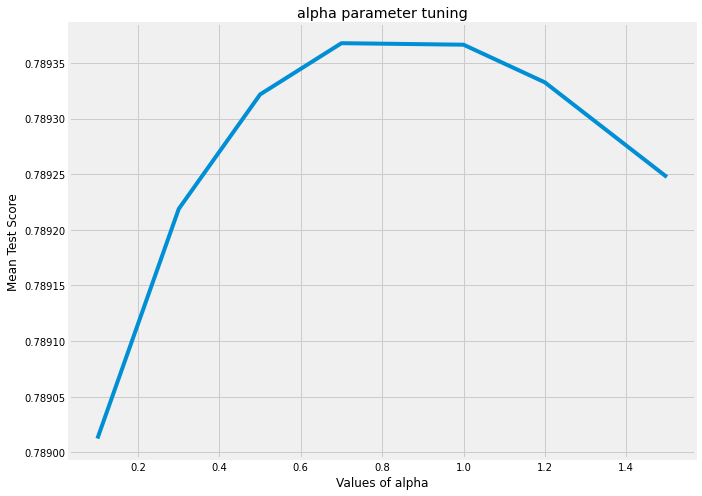

In [82]:
plt.figure(figsize = (10,8))
sns.lineplot(x = result.param_alpha, y = result.mean_test_score)
plt.title("alpha parameter tuning")
plt.xlabel("Values of alpha")
plt.ylabel("Mean Test Score")
print("The best value of alpha is ",(result[result.rank_test_score == 1]).param_alpha.item())
best_alpha = result[result.rank_test_score == 1].param_alpha.item()

In [55]:
ridge = Ridge(alpha = best_alpha)
ridge.fit(combine_x, combine_y)

Ridge(alpha=0.7, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

Lets first look at the training error

In [56]:
pred = ridge.predict(combine_x)
print("The error of ridge regression on training set is ",mean_squared_error(combine_y, pred))

The error of ridge regression on training set is  1048014643.4147161


Now lets look at the test error

In [57]:
pred = ridge.predict(xte)
print("The error of ridge regression on test set is ",mean_squared_error(yte, pred))

The error of ridge regression on test set is  970596012.2414984


In [58]:
test_loss_ridge = mean_squared_error(yte, pred)

#### Kernelized Ridge Regression

Due to less computational resources, I cannot do it because of a large matrix not fitting in memory. 

The kernelized Regression has the capability to calculate higher dimension inner products without actually knowing the higher dimension vector. It can capture more non-linear relationships.

In [59]:
# from sklearn.kernel_ridge import KernelRidge
# clf = KernelRidge(alpha=1.0, kernel= 'rbf')

In [60]:
# clf.fit(xtr, ytr)

In [61]:
# pred = clf.predict(x.reshape(-1,1))

#### Neural Network

Neural Networks can also be used to predict vehicle target_price. In order to avoid overfitting, we are using a dropout layer.

We will tune the "rate" of dropout.

Let's do it

In [62]:
drops = [0, 0.1, 0.3, 0.7, 0.9]
performance = []
for d in drops:
  inp = Input(shape= (xtr.shape[1],))
  x = Dense(32, activation= 'relu')(inp)
  x = Dense(16, activation= 'relu')(x)
  x = Dropout(d)(x)
  x = Dense(1, activation= 'relu')(x)
  model = Model(inputs = inp, outputs = x)
  model.compile(loss= 'mse')
  hist = model.fit(xtr, ytr, validation_data = (xval, yval), epochs = 7)
  performance.append(hist.history['val_loss'][-1])

Epoch 1/7
3323/3323 [==============================] - 22s 2ms/step - loss: 8285315618.5030 - val_loss: 4966279680.0000
Epoch 2/7
3323/3323 [==============================] - 8s 2ms/step - loss: 3211005687.3742 - val_loss: 1872907136.0000
Epoch 3/7
3323/3323 [==============================] - 7s 2ms/step - loss: 1619726128.3947 - val_loss: 1618866944.0000
Epoch 4/7
3323/3323 [==============================] - 8s 2ms/step - loss: 1325283709.7473 - val_loss: 1472186496.0000
Epoch 5/7
3323/3323 [==============================] - 8s 2ms/step - loss: 1270005716.7653 - val_loss: 1321039616.0000
Epoch 6/7
3323/3323 [==============================] - 8s 2ms/step - loss: 1049571152.6931 - val_loss: 1165090944.0000
Epoch 7/7
3323/3323 [==============================] - 7s 2ms/step - loss: 899769884.6691 - val_loss: 1049092608.0000
Epoch 1/7
3323/3323 [==============================] - 8s 2ms/step - loss: 8141392670.0361 - val_loss: 4024327424.0000
Epoch 2/7
3323/3323 [===========================

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Tuning Dropout Rate')

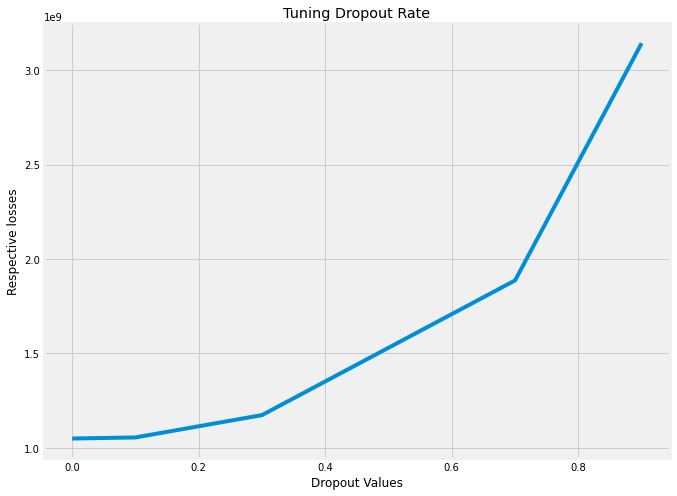

In [63]:
plt.figure(figsize = (10,8))
sns.lineplot(drops, performance)
plt.xlabel("Dropout Values")
plt.ylabel("Respective losses")
plt.title("Tuning Dropout Rate")

The best values occurs with dropout rate = 0.

Let train with this value now

In [64]:
inp = Input(shape= (xtr.shape[1],))
x = Dense(32, activation= 'relu')(inp)
x = Dense(16, activation= 'relu')(x)
x = Dropout(0)(x)
x = Dense(1, activation= 'relu')(x)
model = Model(inputs = inp, outputs = x)
model.compile(loss= 'mse')
hist = model.fit(xtr, ytr, validation_data = (xval, yval), epochs = 7)

Epoch 1/7
3323/3323 [==============================] - 9s 3ms/step - loss: 7926301752.5295 - val_loss: 4300740096.0000
Epoch 2/7
3323/3323 [==============================] - 8s 3ms/step - loss: 2672003983.1721 - val_loss: 1812143104.0000
Epoch 3/7
3323/3323 [==============================] - 8s 2ms/step - loss: 1465678474.0698 - val_loss: 1597016320.0000
Epoch 4/7
3323/3323 [==============================] - 7s 2ms/step - loss: 1301785335.0181 - val_loss: 1451165696.0000
Epoch 5/7
3323/3323 [==============================] - 8s 3ms/step - loss: 1132783495.7016 - val_loss: 1293729024.0000
Epoch 6/7
3323/3323 [==============================] - 8s 2ms/step - loss: 1010249889.6270 - val_loss: 1140560640.0000
Epoch 7/7
3323/3323 [==============================] - 8s 3ms/step - loss: 862589632.8279 - val_loss: 1035840640.0000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Validation losses')

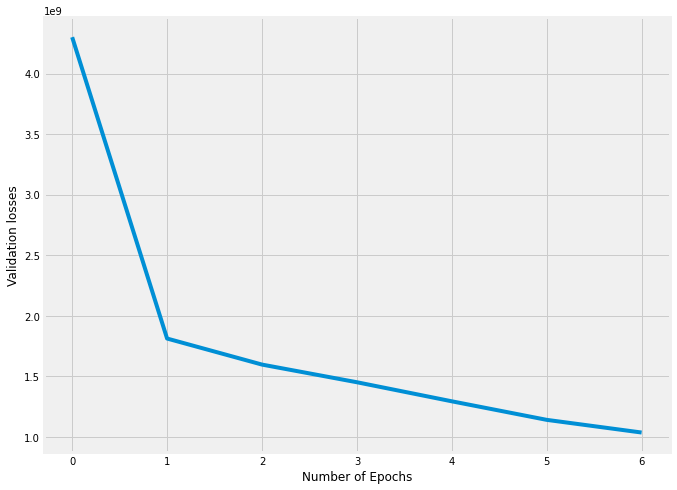

In [65]:
plt.figure(figsize = (10,8))
sns.lineplot(np.arange(len(hist.history['val_loss'])), hist.history['val_loss'])
plt.xlabel("Number of Epochs")
plt.ylabel("Validation losses")

Lets first check the training loss

In [66]:
pred = model(xtr)
print("The training error for neural network is ",mean_squared_error(ytr, pred))

The training error for neural network is  817380160.4156204


Lets check for test set

In [67]:
pred = model(xte)
print("The testing error for neural network is ",mean_squared_error(yte, pred))
test_loss_nn = mean_squared_error(yte, pred)

The training error for neural network is  791225697.72107


#### Compairing losses for all 2 models

Text(0.5, 1.0, 'Compairing Models')

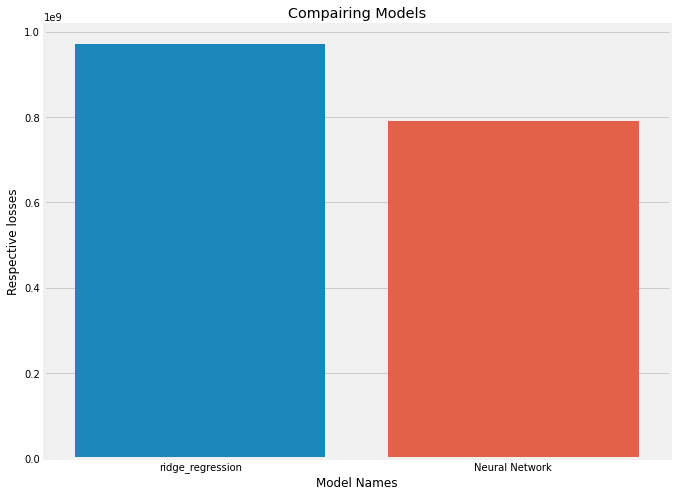

In [70]:
names = ['ridge_regression', 'Neural Network']
score = [test_loss_ridge, test_loss_nn]
plt.figure(figsize = (10,8))
sns.barplot(x = names, y = score)
plt.xlabel("Model Names")
plt.ylabel("Respective losses")
plt.title("Compairing Models")

Clearly, Neural Network performs best out of all implemented models.

## Recommend Further Actions

In my opinion, we can add more features to make the model more strong. While collecting data some of the extra questions that can also be relevant while predicitng a price of a used car can be:

* Colour of the color
* How many times the car has been repaired
* Type of car e.g SUV, wagon, Sedan etc
* Leg space.

One of the other thing is occurance of some car brands only once. This would let the model learn a specific number for a given car make. If the model is tested on the same car make with an expensive car model, our algorithm won't be able to differentiate. My recommendation would be to add only car make which have examples greater than a specific threshold.

Similar goes with the fuel_type and other features. We only have very few examples of fuel_type == 'etanol'. The model would not be able to differentiate BMW or Mercedes-Benz if both operate on etanol.

## Summary

Data consisted of 10 features and a target_price for used cars. Analysis depicted presence of some missing values which were ignored. The numerical features had alot of outliers hence a threshold was decided for each feature after the visual analysis to prevent model getting influenced by them. Different features had different ranges which would have affected the model hence they were analyzed and scaled using z-score. This included making an assumption that these feature follow an approximate bell shape distribution. 

Categorical features were one-hot-encoded to preserve all the information. To predict a continuous variable, three different approaches were selected that are linear regression, ridge regression and finally neural network. Due to the bottleneck on computational resources, Kernelized model could not be implemented.

The 3 models were trained and evaluated on unseen data. The objective function was chosen to be mean squared error which was to be minimized. Some of the basic problems like overfitting and tuning hyperparameters were detected which were taken care of. The Neural Network proved to be most powerful model to predict the car prices.





## Future Work

Future Work may include collecting more data from different resources with new set of features. We can also analyze how the percentage of decrease of price changes through every decade. Furthermore, according to the price range of the customers, most optimized options should be presented. We can also analyze price range for specific car makes to deduce which car brnad has the most rapid decrease in price overtime.